https://www.kaggle.com/competitions/nlp-getting-started

# Проект: "предсказание типа комментариев: о реальных катастрофах и нереальных катастрофах." (Аналитика)

# Импортирование библиотек

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

import re

import nltk
from collections import defaultdict

from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maxim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Предварительный анализ и подготовка данных

In [135]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train = train.drop(columns = ['keyword', 'location'])
test = test.drop(columns = ['keyword', 'location'])

df = pd.concat([train, test])

In [136]:
df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,Forest fire near La Ronge Sask. Canada,1.0
2,5,All residents asked to 'shelter in place' are ...,1.0
3,6,"13,000 people receive #wildfires evacuation or...",1.0
4,7,Just got sent this photo from Ruby #Alaska as ...,1.0


In [137]:
print('Форма train: {}'.format(train.shape))
print('Форма test: {}'.format(test.shape))
print('Форма df=train+test: {}'.format(df.shape))

Форма train: (7613, 3)
Форма test: (3263, 2)
Форма df=train+test: (10876, 3)


In [138]:
print('{}'.format(train.info()), end = '\n\n')
print('{}'.format(test.info()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3263 non-null   int64 
 1   text    3263 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.1+ KB
None


Тестовая выборка меток не имеет, поэтому когда будем анализировать все данные без учета меток будем анализировать df = train + test, когда будет происходить анализ с учетом меток(например, их распределение), то будем использовать только train подвыборку. Пропусков в данных нету.

In [139]:
df.drop_duplicates()
print(f"Размер данных после удаления дубликатов:", df.shape)

Размер данных после удаления дубликатов: (10876, 3)


In [140]:
print(f'Всего твитов в данных:', df.shape[0])
print('Всего уникальных пользователей в данных: {}'.format(df['id'].nunique()))

Всего твитов в данных: 10876
Всего уникальных пользователей в данных: 10876


In [141]:
print('Всего меток твитов в данных: {}'.format(len(train['target'].unique())))
print('Уникальные метки твитов: {}'.format(train['target'].unique()), end = '\n\n')
print('Количество меток каждого типа твитов:\n{}'.format(train['target'].value_counts()))

Всего меток твитов в данных: 2
Уникальные метки твитов: [1 0]

Количество меток каждого типа твитов:
0    4342
1    3271
Name: target, dtype: int64


Количество меток каждого типа твитов резко не отличаются, баланс классов примерно соблюдается.

# Разведочный анализ данных

## Распределение меток твитов

In [142]:
target_distr = pd.DataFrame(data=train.groupby('target')['target'].count())
target_distr.columns = ['count']
target_distr = target_distr.sort_values(by = 'count', ascending=False)
target_distr

,count
target,
0,4342
1,3271


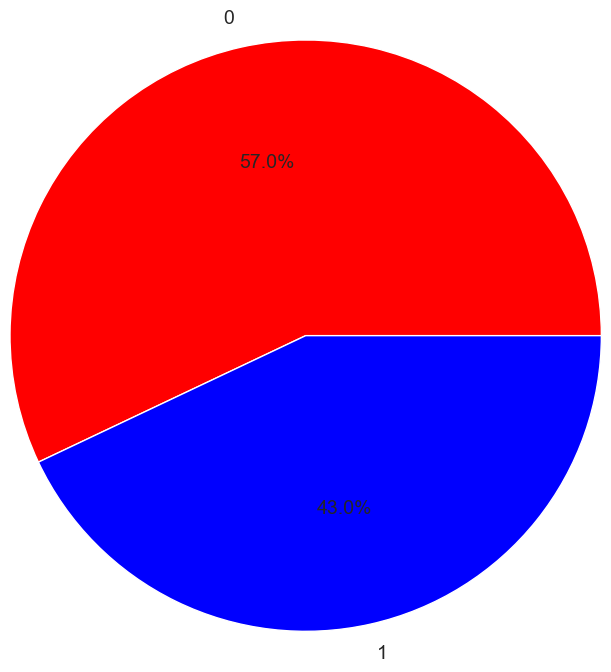

In [143]:
percent_class = list(target_distr['count'])
labels = list(target_distr.index)

colors = ['red', 'blue']

plt.pie(percent_class,radius = 2, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})

plt.show()

## Распределение количества символов и слов в тексте

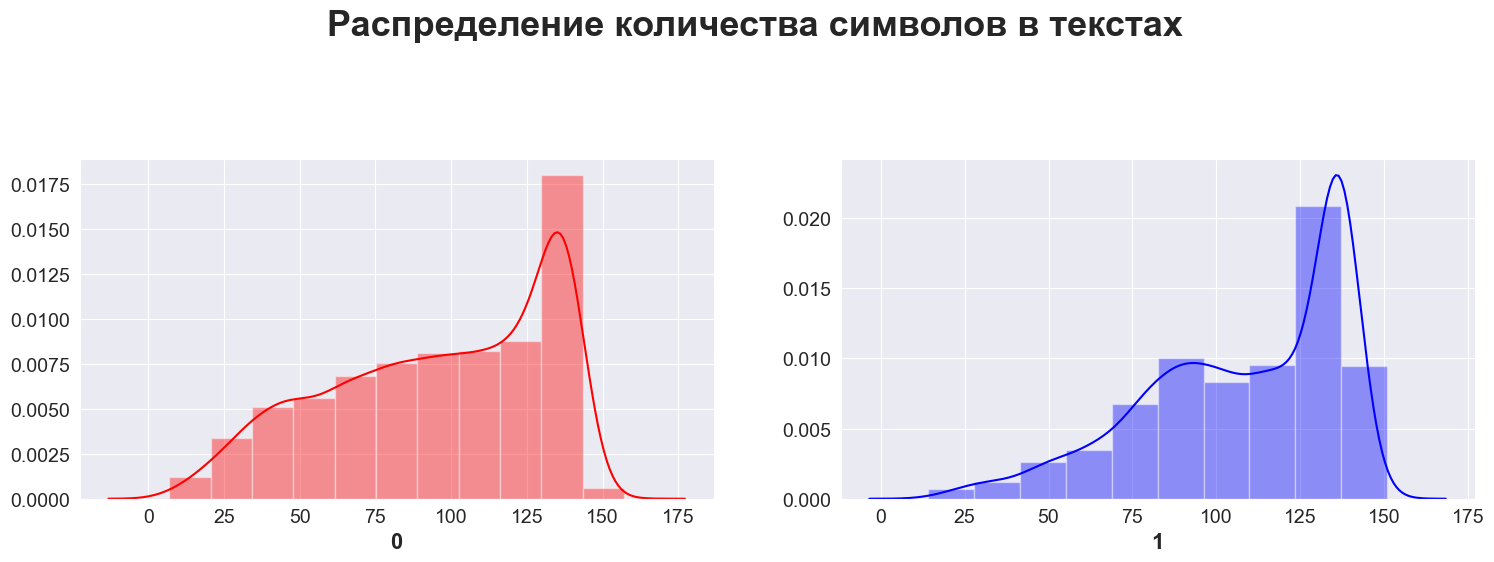

In [144]:
sns.set_style('darkgrid')

plt.figure(figsize=(18, 15))
plt.suptitle('Распределение количества символов в текстах', fontsize = 26, fontweight = 'bold')

for index, target in enumerate(labels):
    plt.subplot(3, 2, index+1)
    tweet_len_char=train[train['target']==target]['text'].str.len() # Количество символов в твите
    sns.distplot(a=tweet_len_char, bins=int((max(tweet_len_char) - min(tweet_len_char)) /
             (1 + 3.322*np.log10(len(tweet_len_char)))), color=colors[index]) 

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(target, fontsize=16, fontweight='bold')
    plt.ylabel('')
plt.show()

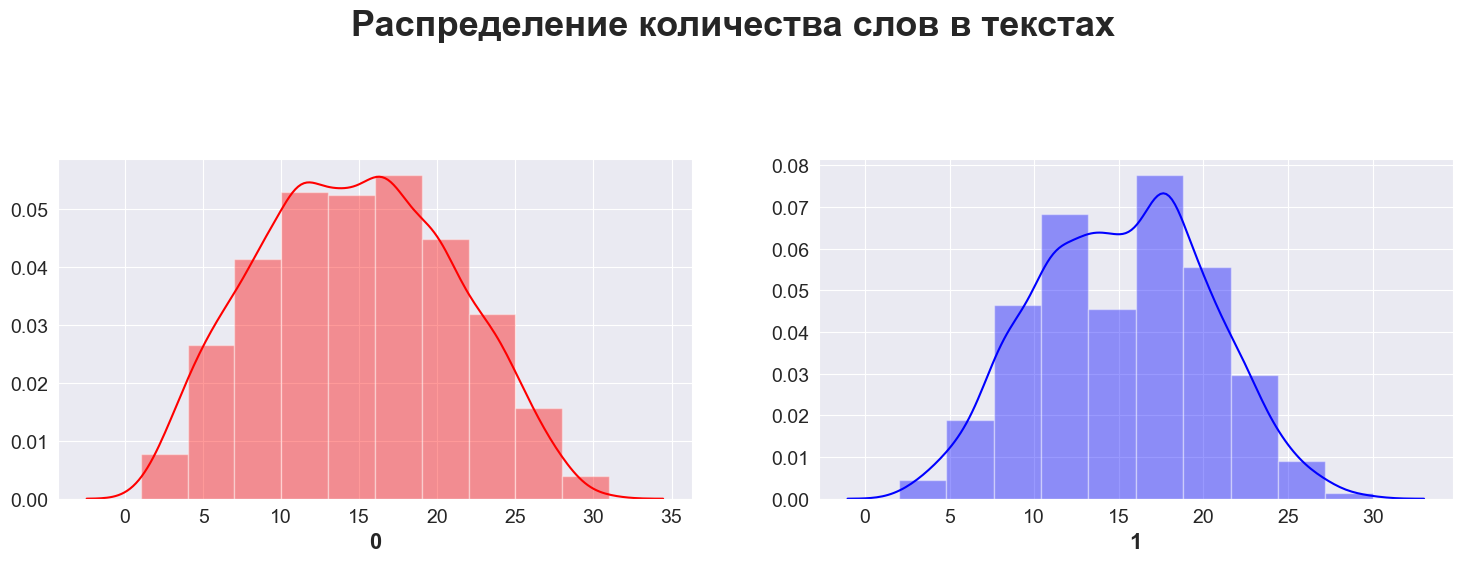

In [145]:
plt.figure(figsize=(18, 15))
plt.suptitle('Распределение количества слов в текстах',
             fontsize=26, fontweight='bold')

for index, target in enumerate(labels):
    plt.subplot(3, 2, index+1)
    tweet_len_word = train[train['target'] == target]['text'].str.split().apply(
        lambda x: [len(i) for i in x]).map(lambda x: len(x)) # количество слов в твите
    sns.distplot(a=tweet_len_word, bins=10, color=colors[index])

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(target, fontsize=16, fontweight='bold')
    plt.ylabel('')
plt.show()

## Популярность слов в твитах

In [146]:
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maxim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


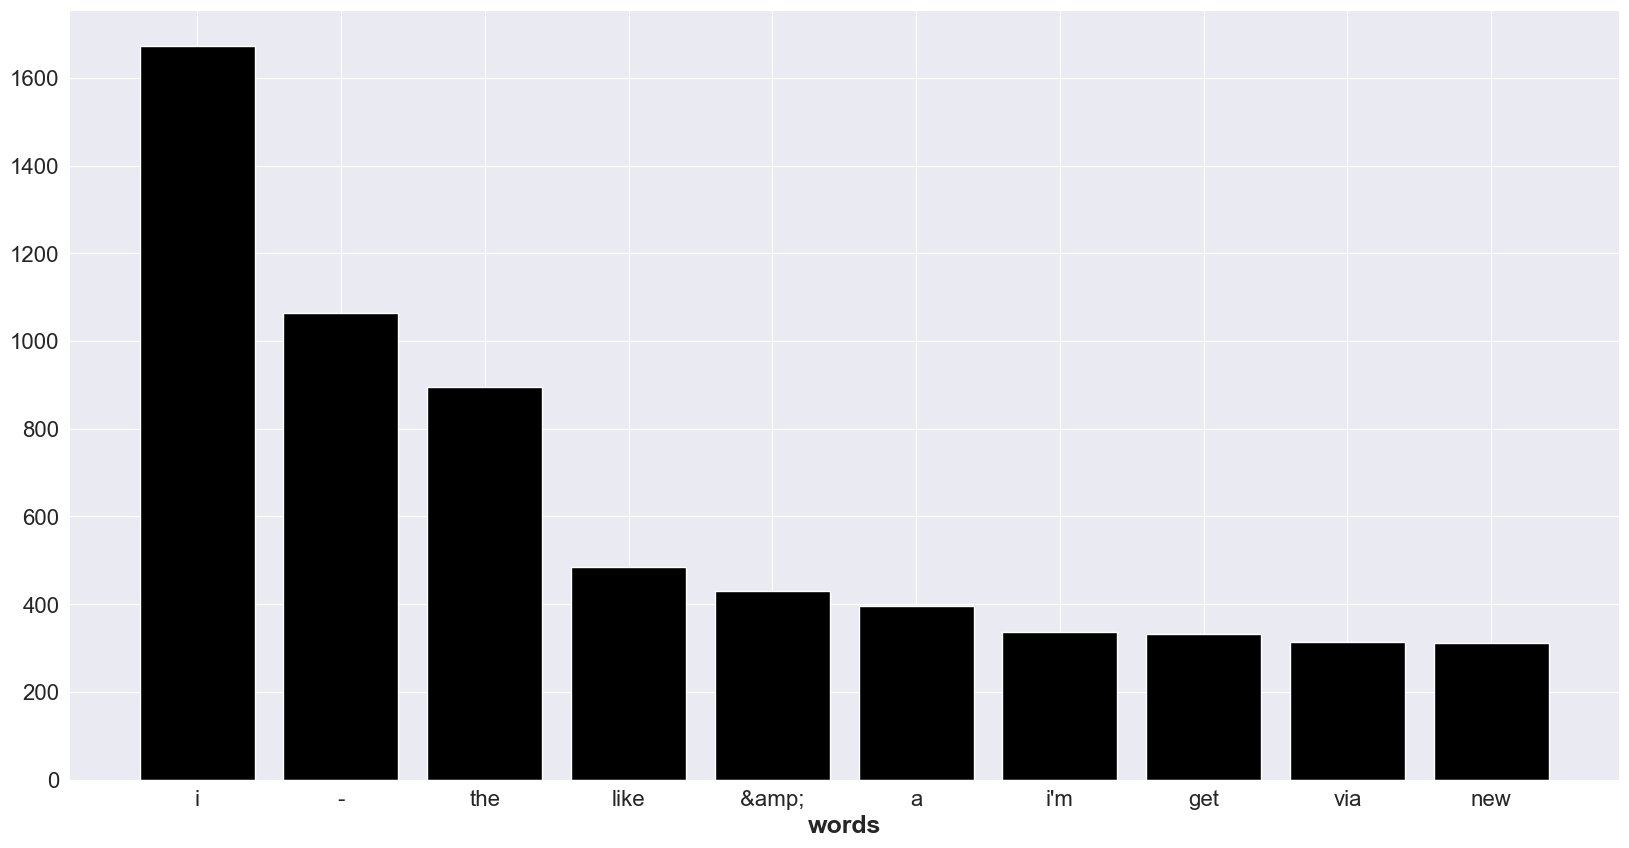

In [147]:
plt.figure(figsize = (20, 10))

corpus = []
for text in df['text'].str.split():
    for word in text:
        corpus.append(word)

dic=defaultdict(int)
for word in corpus:
    if word not in STOPWORDS:
        dic[word.lower()] += 1
            
top=sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10] 
x, y = zip(*top)

plt.bar(x, y, color = 'black')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('words', fontsize = 18, fontweight = 'bold')
plt.show()

## Популярные хэштеги в твитах

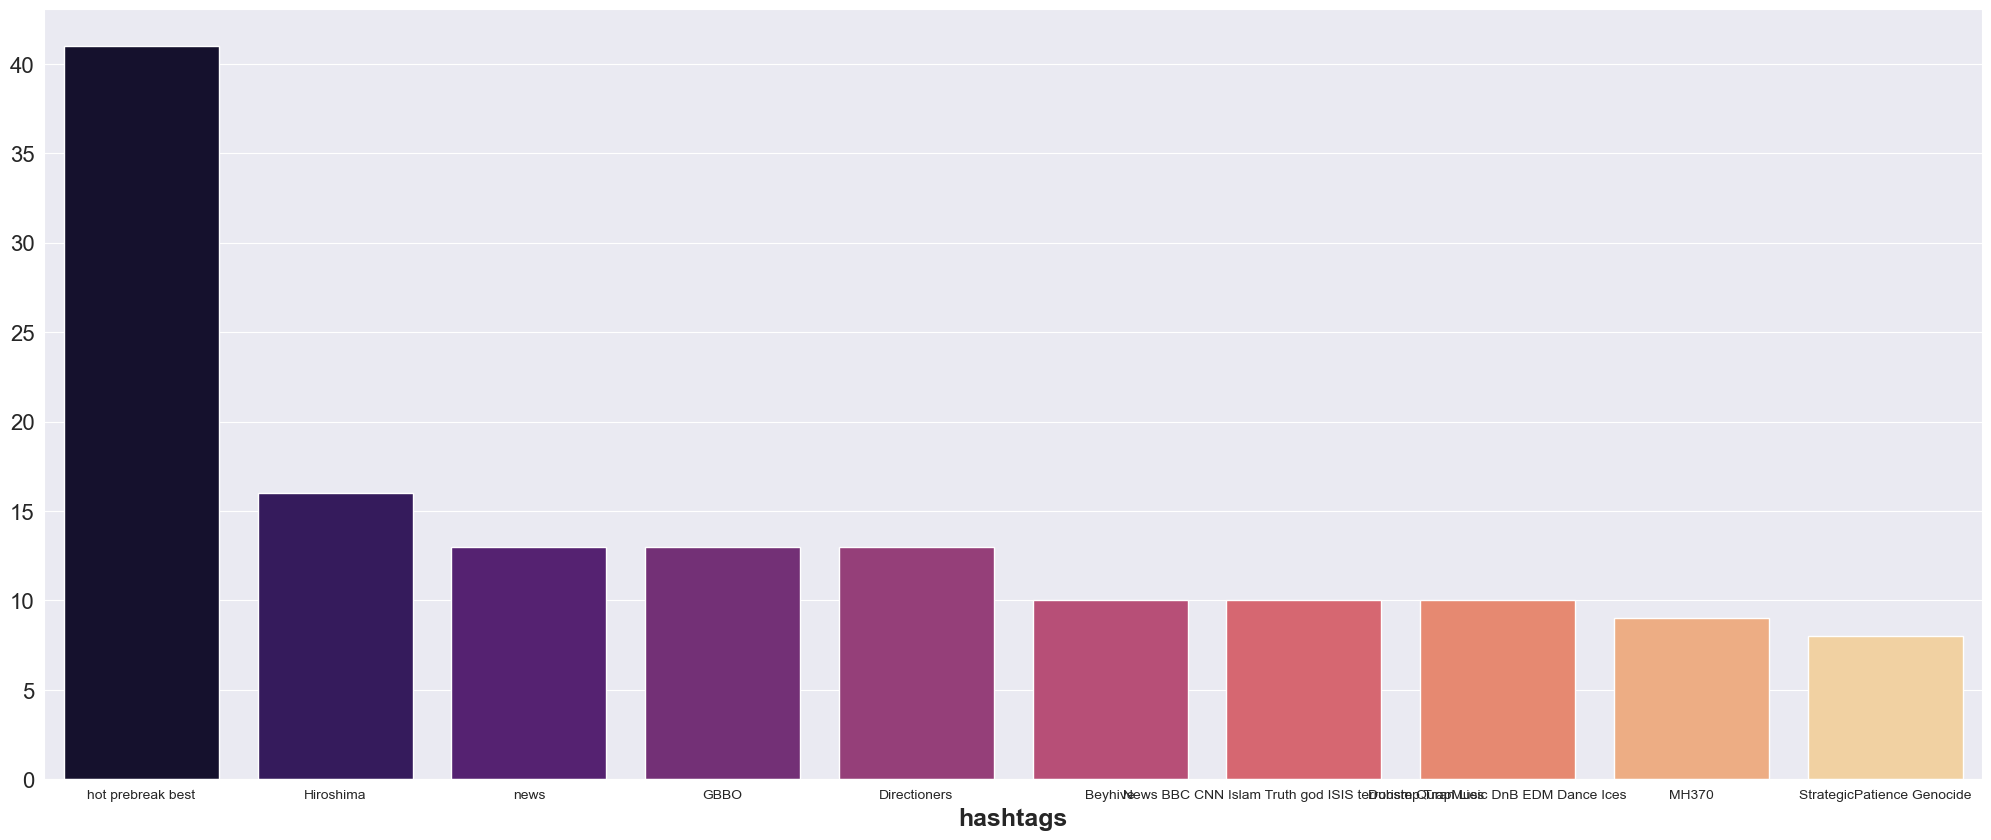

In [148]:
def find_hash(text):
    line = re.findall('(?<=#)\w+', text)
    return ' '.join(line)

df['hash'] = df['text'].apply(lambda x: find_hash(x))
temp = df['hash'].value_counts()[1:11]
temp = temp.to_frame().reset_index().rename(columns={'index':'Hashtag','hash':'count'})

plt.figure(figsize = (25, 10))
sns.barplot(x="Hashtag", y="count", data = temp, palette = 'magma')

plt.xticks(fontsize=10)
plt.yticks(fontsize=16)
plt.xlabel('hashtags', fontsize = 18, fontweight = 'bold')
plt.ylabel('')
plt.show()

## Популярные отсылки(@) в твитах

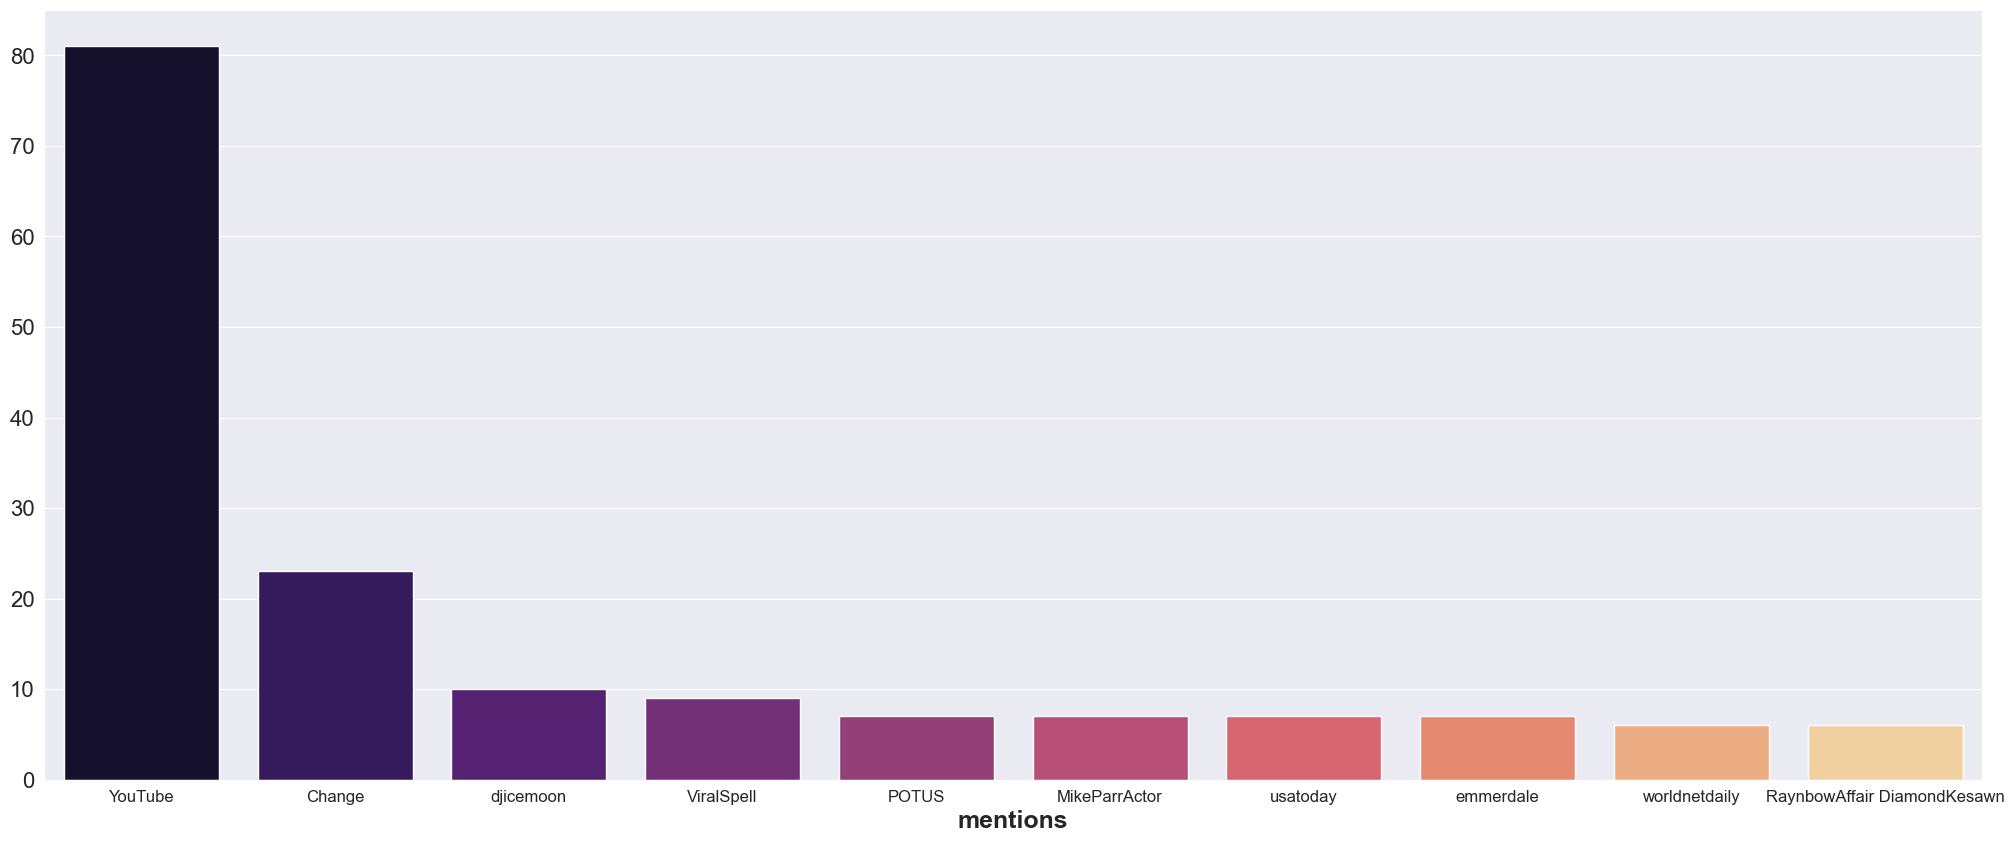

In [149]:
def mentions(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)

df['mentions']=df['text'].apply(lambda x: mentions(x))
temp = df['mentions'].value_counts()[1:11]
temp = temp.to_frame().reset_index().rename(columns={'index':'mentions','mentions':'count'})

plt.figure(figsize = (25, 10))
sns.barplot(x='mentions',y='count', data = temp, palette = 'magma')

plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.xlabel('mentions', fontsize = 18, fontweight = 'bold')
plt.ylabel('')
plt.show()